<a href="https://colab.research.google.com/github/vohnjogel/lab-5-vohnjogel/blob/main/DATA_301_Lab_5_John_Vogel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authorship of the Federalist Papers

The _Federalist Papers_ were a set of 85 essays published between 1787 and 1788 to promote the ratification of the United States Constitution. They were originally published under the pseudonym "Publius". Although the identity of the authors was a closely guarded secret at the time, most of the papers have since been conclusively attributed to one of Hamilton, Jay, or Madison. The known authorships can be found in `https://dlsun.github.io/pods/data/federalist/authorship.csv`.

For 15 of the papers, however, the authorships remain disputed. (These papers can be identified from the `authorship.csv` file because the "Author" field is blank.) In this analysis, you will use the papers with known authorship to predict the authorships of the disputed papers. The text of each paper is available at `https://dlsun.github.io/pods/data/federalist/x.txt`, where `x` is the number of the paper (i.e., a number from 1 to 85). The name of the file indicates the number of the paper.

In [1]:
import pandas as pd
import requests
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

df_authorship = pd.read_csv('https://dlsun.github.io/pods/data/federalist/authorship.csv')
df_authorship.head()

,Paper,Author
0,1,Hamilton
1,2,Jay
2,3,Jay
3,4,Jay
4,5,Jay


In [2]:
df_known = df_authorship.dropna()
df_known.head()

,Paper,Author
0,1,Hamilton
1,2,Jay
2,3,Jay
3,4,Jay
4,5,Jay


In [3]:
df_unknown = df_authorship[df_authorship['Author'].isna()]
df_unknown.head()

,Paper,Author
17,18,NaN
18,19,NaN
19,20,NaN
48,49,NaN
49,50,NaN


## Question 1

When analyzing an author's style, common words like "the" and "on" are actually more useful than rare words like "hostilities". That is because rare words typically signify context. Context is useful if you are trying to find documents about similar topics, but not so useful if you are trying to identify an author's style because different authors can write about the same topic. For example, both Dr. Seuss and Charles Dickens used rare words like "chimney" and "stockings" in _How the Grinch Stole Christmas_ and _A Christmas Carol_, respectively. But they used common words very differently: Dickens used the word "upon" over 100 times, while Dr. Seuss did not use "upon" even once.

Read in the Federalist Papers. Convert each one into a vector of term frequencies. In order to restrict to common words, include only the top 50 words across the corpus. (Because we are restricting to the most common words already, there is no reason to reweight them using TF-IDF.)

In [4]:
fed_dir = 'https://dlsun.github.io/pods/data/federalist/'
docs_fed = pd.Series()

# read in each paper as entry in series
for i in range(1, 86):
  response = requests.get(fed_dir + str(i) + '.txt', 'r')
  docs_fed[str(i)] = response.text

docs_fed.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


1    To the People of the State of New York:\n\nAFT...
2    To the People of the State of New York:\n\nWHE...
3    To the People of the State of New York:\n\nIT ...
4    To the People of the State of New York:\n\nMY ...
5    To the People of the State of New York:\n\nQUE...
dtype: object

In [5]:
vec = CountVectorizer()
vec.fit(docs_fed)
tf_sparse = vec.transform(docs_fed)

tf_sparse

<85x8616 sparse matrix of type '<class 'numpy.int64'>'
	with 59720 stored elements in Compressed Sparse Row format>

In [6]:
tf_sparse.todense()

matrix([[0, 0, 0, ..., 3, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 2, 0, 0],
        [0, 0, 0, ..., 1, 0, 2]])

In [7]:
tf_vectors = pd.DataFrame(
    tf_sparse.todense(),
    columns=vec.get_feature_names()
)

tf_vectors.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,10,11,128,13,136,13th,1648,1683,1685,1688,1706,1726,1774,1783,1784,1786,1787,1808,181,186,195,1st,257,262,2d,30,31,3d,438,4th,5th,81,abandon,abandoned,abandoning,abate,abatements,abbe,abetted,...,wounded,wreaked,wreck,wrest,wretched,writ,write,writer,writers,writing,writings,written,wrong,wrongs,wrought,wyoming,xerxes,xiv,xv,yards,yates,year,yearly,years,yeomanry,yes,yet,yield,yielding,yoke,yokes,york,you,young,your,yourselves,zaleucus,zeal,zealand,zealous
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,7,0,10,0,0,3,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,3,0,0,0,0,1,1,1,3,1,0,0,0,0


In [8]:
# make series of 50 most common words in corpus
word_counts = pd.Series(tf_vectors.sum(axis=0)).sort_values(ascending=False)[:50]
word_counts.head()

the    17767
of     11824
to      7074
and     5099
in      4456
dtype: int64

In [9]:
# select columns for 50 most common words
top_words = word_counts.index.tolist()
tf_vectors = tf_vectors[top_words]
tf_vectors.head()

,the,of,to,and,in,be,that,it,is,which,by,as,this,would,have,will,for,or,not,their,with,from,are,on,they,an,states,government,may,been,state,all,but,its,other,people,power,has,more,at,if,than,them,one,any,no,those,can,constitution,we
0,133,106,72,40,27,34,28,20,13,18,14,10,14,2,10,25,12,6,14,14,6,11,12,9,6,11,2,9,11,3,6,9,2,10,3,6,2,6,7,8,4,11,2,4,6,3,9,3,8,8
1,107,83,53,83,34,15,44,38,16,11,10,16,14,5,17,2,13,10,10,21,13,4,6,8,22,1,2,9,4,8,1,4,8,5,4,23,1,6,5,10,3,5,4,10,1,1,2,0,0,5
2,93,62,56,60,25,31,20,21,7,11,18,24,6,2,7,24,11,32,13,11,10,15,8,6,5,3,11,16,6,2,8,4,7,1,7,8,3,5,13,1,7,8,8,8,5,2,6,3,0,0
3,86,72,51,90,24,26,17,28,10,10,14,20,1,17,9,15,12,24,14,19,12,8,11,11,17,3,1,16,10,2,6,4,10,9,11,8,2,1,13,2,14,9,12,13,5,1,4,8,0,10
4,66,53,45,72,28,31,23,21,7,10,10,3,6,37,1,7,7,10,8,11,11,11,3,5,11,4,1,2,2,0,2,4,4,4,4,3,1,0,11,4,3,9,11,10,3,2,9,1,0,5


## Question 2
Make a visualization that summarizes the most common words used by Hamilton, Madison, and Jay.

In [10]:
df_hamilton = df_known[df_known['Author'] == 'Hamilton']
df_ham_vecs = tf_vectors.iloc[df_hamilton['Paper'].index.tolist()]
ham_word_counts = df_ham_vecs.sum(axis=0)
ham_wc = ham_word_counts.sum()
ham_word_freqs = ham_word_counts.divide(ham_wc)
ham_word_freqs.head()  # how often each word appears compared to other common words

the    0.186215
of     0.130600
to     0.081934
and    0.048469
in     0.050412
dtype: float64

In [11]:
df_madison = df_known[df_known['Author'] == 'Madison']
df_mad_vecs = tf_vectors.iloc[df_madison['Paper'].index.tolist()]
mad_word_counts = df_mad_vecs.sum(axis=0)
mad_wc = mad_word_counts.sum()
mad_word_freqs = mad_word_counts.divide(mad_wc)
mad_word_freqs.head()

the    0.201684
of     0.120628
to     0.065144
and    0.060133
in     0.041742
dtype: float64

In [12]:
df_jay = df_known[df_known['Author'] == 'Jay']
df_jay_vecs = tf_vectors.iloc[df_jay['Paper'].index.tolist()]
jay_word_counts = df_jay_vecs.sum(axis=0)
jay_wc = jay_word_counts.sum()
jay_word_freqs = jay_word_counts.divide(jay_wc)
jay_word_freqs.head()

the    0.130781
of     0.091745
to     0.072849
and    0.101442
in     0.040776
dtype: float64

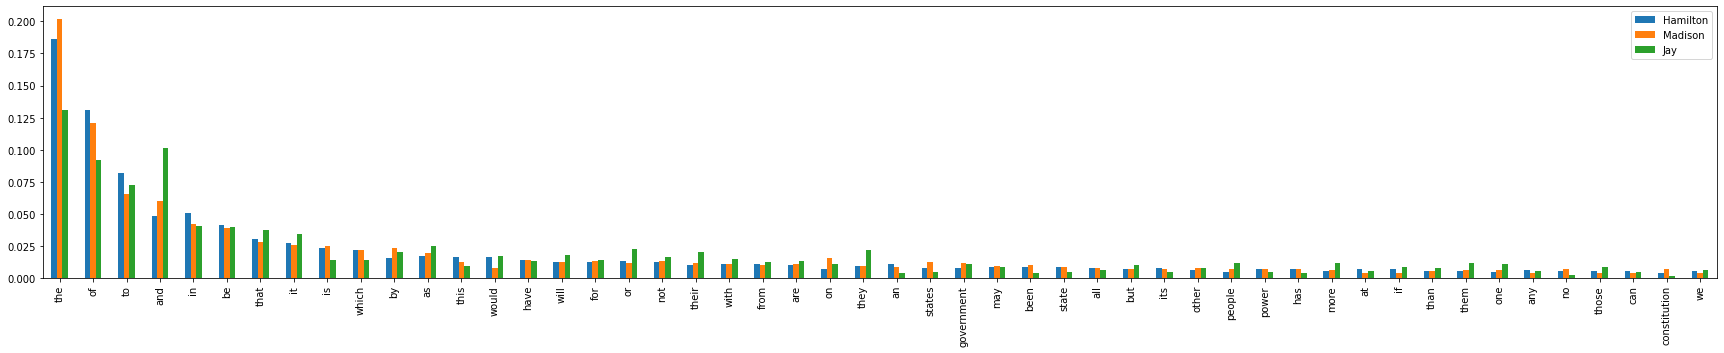

In [13]:
df_word_freqs = pd.DataFrame()
df_word_freqs['Hamilton'] = ham_word_freqs
df_word_freqs['Madison'] = mad_word_freqs
df_word_freqs['Jay'] = jay_word_freqs
df_word_freqs.plot.bar(figsize=(30,5))

## Question 3

For each of the documents with disputed authorships, find the 5 most similar documents with _known_ authorships, using cosine distance on the term frequencies. Use the authors of these 5 most similar documents to predict the author of each disputed document. (For example, if 3 of the 5 closest documents were written by Hamilton, 1 by Madison, and 1 by Jay, then we would predict that the disputed document was written by Hamilton.)

In [14]:
for i in df_unknown.index:
  sims = pd.Series(cosine_similarity(tf_sparse)[i]).sort_values(ascending=False)
  most_sim = sims.iloc[1:6].index.tolist()  # 0-indices of 5 most similar docs
  author = df_authorship.iloc[most_sim]['Author'].mode().values[0]  # select most common author from similar docs
  df_unknown.at[i, 'Author'] = author

df_unknown

,Paper,Author
17,18,Madison
18,19,Madison
19,20,Madison
48,49,Hamilton
49,50,Madison
50,51,Madison
51,52,Madison
52,53,Madison
53,54,Hamilton
54,55,Madison


## Submission Instructions

- Copy this notebook to your own Drive, if you have not already.
- Restart this notebook and run the cells from beginning to end. 
  - Go to Runtime > Restart and Run All.
- Rename this notebook by clicking on "DATA 301 Lab 5 - YOUR NAMES HERE" at the very top of this page. Replace "YOUR NAMES HERE" with the first and last names of you (and your partners, for Phase 2).
- Get the link to your notebook:
  - Click on "Share" at the top-right. 
  - Change the settings to "Anyone with the link can view". 
  - Copy the sharing link into Canvas.